# Lab 8-3: Example timeseries analysis with FFT

In this example, we will create a fake timeseries dataset, with periodicity based on properties that are typical for a lot of natural systems such as streamflow fed by snowmelt, or air temperatures. We will add random noise to our dataset. Then, we'll use Fast Fourier Transform (FFT) to try and characterize the periodicity (find the dominant frequencies or periods) of our dataset.

(Derived from CEE599_timeseries.m, Nov. 2015, Jessica Lundquist. Converted to python Nov. 2019, Steven Pestana. Updated Nov. 2023, Steven Pestana)

***


Import packages we need for our anlaysis

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio # we'll use scipy's IO library to read .mat files

## Create some periodic timeseries data

We're going to pretend that this is streamflow from a watershed where snow or a glacier is melting as a function of air temperature. To simplify the problem, we are going to consider two frequencies at which the streamflow varies: the annual seasonal cycle, and the daily cycle. Our timeseries will be hourly, measured in decimal days. Streamflow will be in cubic meters per second (m^3 s^-1, or "cms")

First, create fake streamflow data with 3 components, an overall mean (baseflow), an annual cycle, and a diurnal cycle.

In [2]:
# Create time variable (decimal days)
n_years = 10
t = np.linspace(0,n_years*365,(n_years*365)*24) # 2 years, sampled hourly, measured in decimal days (no leap years)

# Create fake streamflow with 3 components
Qmeanflow_weight = 15
Qmeanflow = Qmeanflow_weight*np.ones(t.size); # 15 cms baseflow all the time

Qseasonal_weight = 10
Qseasonal = Qseasonal_weight*np.sin(2*np.pi*(t-60)/365); # annual repeat cycle, peak in May

Qdaily_weight = 1
Qdaily = Qdaily_weight*np.sin(2*np.pi*(t-6/24)); # diurnal cycle, peak at noon

Next, create some lower-frequency (i.e. "Brownian" or "red") noise, and noise across all frequencies ("white noise"), and add these to our dataset. This is an acceptable approximation of the the random variations in nature for this example.

In [3]:
def rednoise(r,var,N):
    '''
    # r is the lag-1 correlation coefficient
    # var is the variance in the original white noise spectrum
    # N is the length of the series.
    '''
    xwhite = np.sqrt(var)*np.random.normal(size=N) # create some white noise
    xred = xwhite # start off with white
    for ii in range(2,N): # add more red, mix, and repeat
        xred[ii] = r*xred[ii-1] + np.sqrt(1-r**2)*xwhite[ii]
    
    return xred

In [4]:
# red noise (lower frequency)
sigmaR = 3 #set the variance of the red noise
r = 0.99 # This is the weighting of the lag-1 regression model (how much does each step
# depend on the step prior) -- try varying it from 0.5 to 0.99
var = 1 #This is the variance of the white noise in the lag-1 regression model -- try varying it as well
rednoise = sigmaR*rednoise(r,var,t.size) #see rednoise function above

# white noise (all frequencies)
sigmaW = 0.2 #set the variance of the white noise
whitenoise = sigmaW*np.random.normal(size=t.size) # make some white noise

Add together all of our fake data components to create our final streamflow dataset.

In [5]:
Qsum = Qmeanflow + Qseasonal + Qdaily + whitenoise + rednoise # simulate data by summing all these components together

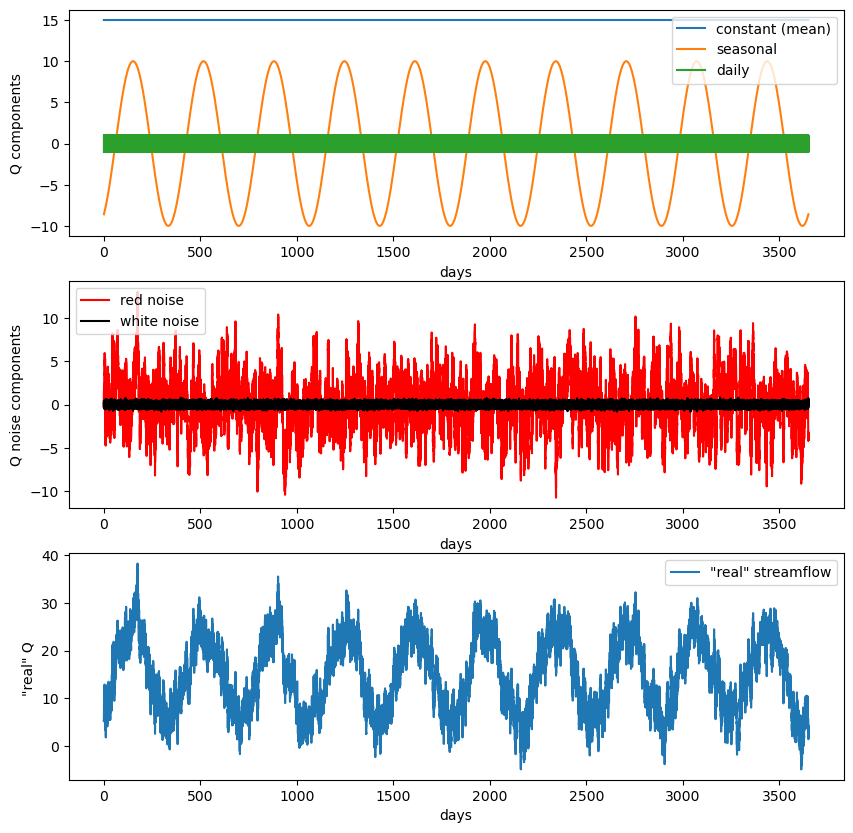

In [6]:
f, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].plot(t,Qmeanflow,'-',label='constant (mean)')
ax[0].plot(t,Qseasonal,'-',label='seasonal')
ax[0].plot(t,Qdaily,'-',label='daily')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Q components')
ax[0].set_xlabel('days')

ax[1].plot(t,rednoise,'r',label='red noise')
ax[1].plot(t,whitenoise,'k',label='white noise')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Q noise components')
ax[1].set_xlabel('days')


ax[2].plot(t,Qsum, label='"real" streamflow')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('"real" Q ')
ax[2].set_xlabel('days');

After working through this example once, change the weights and variances on the different components of the fake streamflow data. See how your changes affect the results of the FFT analysis below.

---

## Analysis with FFT

We will now use FFT to decompose the timeseries dataset we've create into its component parts. Because we created our data, we have an idea about what the results should be. We expect the FFT analysis to show that our dataset has high "power" or "spectral density" at frequencies of 1/day and 1/year.

Read the documentation for the [numpy.fft.fft](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) function that we'll be using. Note that it mentions that this implementation of FFT is most efficient when evaluating datasets with an even number of timesteps.

In [7]:
N = len(Qsum) # make sure our dataset is even
print(N)

87600


In [8]:
# fft of Qsum
X = np.fft.fft(Qsum)
X.shape

(87600,)

In [9]:
X

array([1318147.08071679    +0.j        ,    7730.15983884 +7729.43281669j,
          6813.72219895 -4875.65283912j, ...,
          1784.62142421+10134.97895713j,    6813.72219895 +4875.65283912j,
          7730.15983884 -7729.43281669j])

We can see that our result above has the same shape as our input timeseries, however instead of number of timesteps this is all the frequencies that our data were analyzed at. Also, our result is an array of complex numbers, where each number in the array has a real part and an imaginary part in the format x + yj where y=sqrt(-1). We can access each part as follows:

In [10]:
# print the second number in our result
print(X[1])

# print the real component, corresponding to cosine coefficients
print(X[1].real)

# print the imaginary component, corresponding to sine coefficients
print(X[1].imag)

(7730.159838837217+7729.432816692975j)
7730.159838837217
7729.432816692975


In [11]:
#sines = np.zeros_like(X)
#cosines = np.zeros_like(X)
#for n in range(1,int(N/2+1)): # values are offset by one because the first one has the mean (no sine or cosine)
#    sines[n-1] = -X[n].imag / (N/2) # sine coefficients
#    cosines[n-1] = X[n].real / (N/2)  # cosine coefficients

To get the frequencies all these values correspond to, we can use the [np.fft.fftfreq](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html#numpy.fft.fftfreq) function. (Also, what's up with [negative frequencies](https://dsp.stackexchange.com/a/449)? "...but if you already know that it's a real signal, the other side of the spectrum doesn't provide any extra information, so it's often hand-waved and ignored...")

In [12]:
sample_spacing = 1/24 # our sample spacing in time, in units of days (see how we defined t for our timeseries above)

# returns frequency in cycles per unit of the sample spacing
freqs = np.fft.fftfreq(N, sample_spacing) # compute frequencies giving the number of timesteps (N) and the spacing between each timesetep

# only look at positive frequencies
X = X[freqs>0]
freqs = freqs[freqs>0]

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


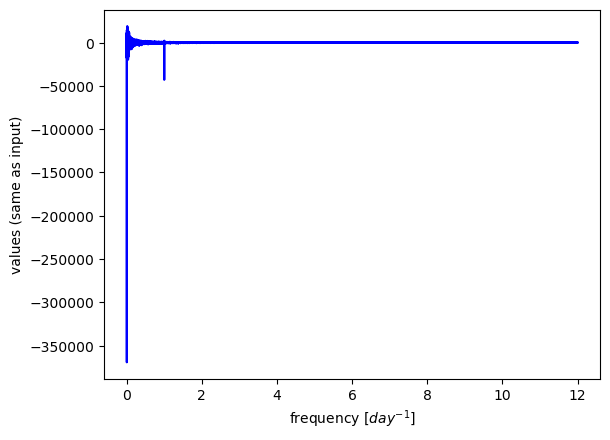

In [13]:
plt.plot(freqs, X, 'b')
plt.xlabel('frequency [$day^{-1}$]')
plt.ylabel('values (same as input)');

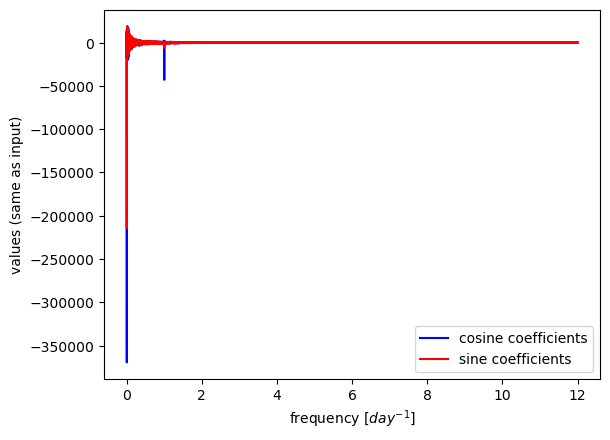

In [14]:
plt.plot(freqs,X.real,c='b',label='cosine coefficients')
plt.plot(freqs,X.imag,c='r',label='sine coefficients')
plt.xlabel('frequency [$day^{-1}$]')
plt.ylabel('values (same as input)')
plt.legend();

In [15]:
recoveredmean = X[0]/N


---
## Power spectral density
Often we don't want the actual coefficients of the sines and cosines, we just want to know at what frequencies our data are varying

Create a Power Spectral Density plot:

In [16]:
p = np.abs(X) # take absolute value to "fold over" power for PSD

This basically calculates the amount of energy (or variance) at different frequencies in the timeseries.

Is there a diurnal cycle, a seasonal cycle, or is it close to red noise you square the complex conjugates?

It's often useful to plot this on log scales as well as regular scales to see what is happening.

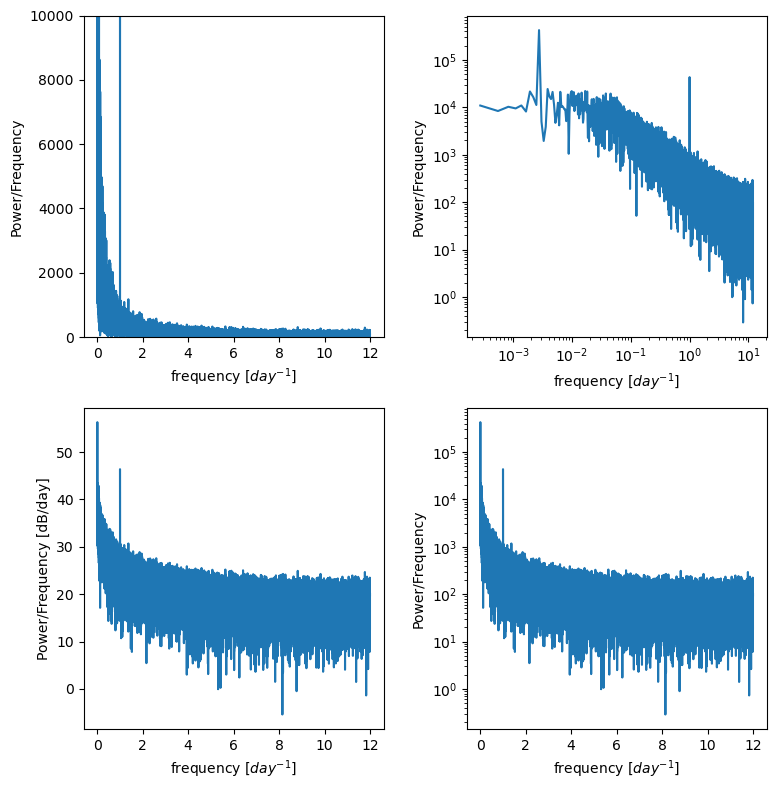

In [17]:
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(freqs,p)
ax[0,0].set_ylim((0,10000)) # zoom in on the y axis
ax[0,0].set_ylabel('Power/Frequency')
ax[0,0].set_xlabel('frequency [$day^{-1}$]')

ax[0,1].plot(freqs,p)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Power/Frequency')
ax[0,1].set_xlabel('frequency [$day^{-1}$]')


ax[1,0].plot(freqs,10*np.log10(p)) # power in decibels
ax[1,0].set_ylabel('Power/Frequency [dB/day]')
ax[1,0].set_xlabel('frequency [$day^{-1}$]')

ax[1,1].plot(freqs,p)
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Power/Frequency')
ax[1,1].set_xlabel('frequency [$day^{-1}$]')

plt.tight_layout()


---
## Reducing noise by averaging multiple PSD plots.

For example if we have this dataset but we're really only trying to resolve the diurnal cycle, we don't need to analyze all 10 years at once. We can divide up the timeseries into smaller chunks, compute the PSD for each, and then take the average of all the chunks. If there is random noise, the hope is that noise will cancel out with each other and the signal we're looking for will stand out more clearly.

In [18]:
n_window = 10 # Divide our full timeseries into multiple "windows" or chunks (make sure we're getting a whole number for window_size)
window_size = N/n_window
print(f'reshaping into {window_size} by {n_window}')
Qsum_reshaped = np.reshape(Qsum,(int(window_size),int(n_window)),order='F')

reshaping into 8760.0 by 10


Define a function that compute fft, and returns the frequencies and powers to create a PSD plot.

In [19]:
def power_spectral_density(x, sample_spacing):
    # get length of our dataset
    N = len(x)

    # compute fft
    X = np.fft.fft(x)
    
    # returns frequency in cycles per unit of the sample spacing
    freqs = np.fft.fftfreq(N, sample_spacing) # compute frequencies giving the number of timesteps (N) and the spacing between each timesetep

    # only look at positive frequencies
    X = X[freqs>0]
    freqs = freqs[freqs>0]
    
    p = np.abs(X) # take absolute value to "fold over" power for PSD
    
    return freqs, p

In [20]:
# create empty array to put our results in
p_window = np.zeros((int(window_size/2)-1, int(n_window)))

# Peform fft on each of the subsets of the total timeseries
for m in range(int(n_window)):
    f_window , p_window[:,m] = power_spectral_density(Qsum_reshaped[:,m],sample_spacing);  

# take the mean of the power across all windows
p_mean = np.mean(p_window,axis=1)

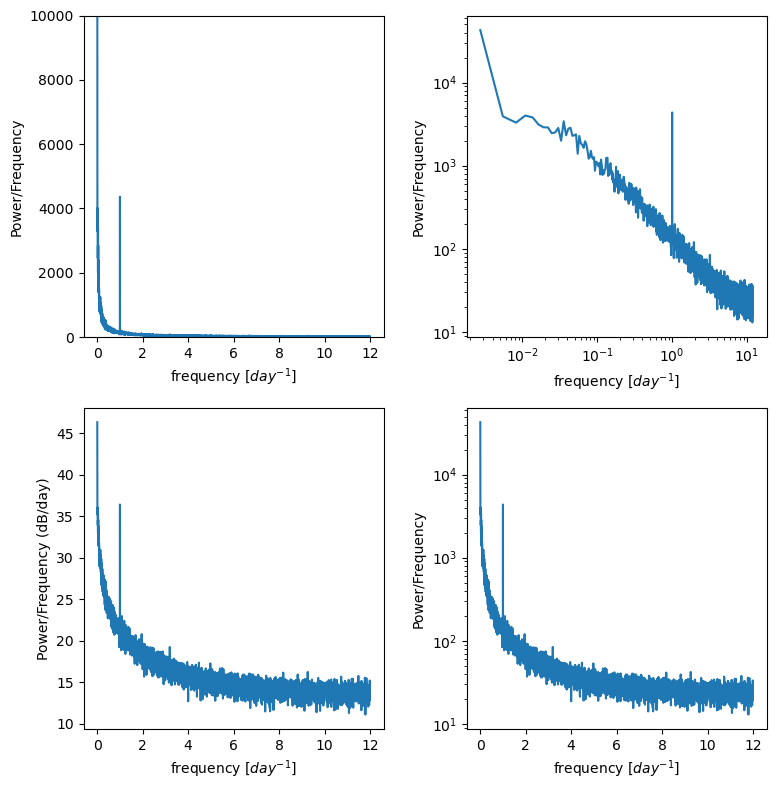

In [21]:
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].plot(f_window,p_mean)
ax[0,0].set_ylim((0,10000)) # zoom in on the y axis
ax[0,0].set_ylabel('Power/Frequency')
ax[0,0].set_xlabel('frequency [$day^{-1}$]')

ax[0,1].plot(f_window,p_mean)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Power/Frequency')
ax[0,1].set_xlabel('frequency [$day^{-1}$]')


ax[1,0].plot(f_window,10*np.log10(p_mean)) # power in decibels
ax[1,0].set_ylabel('Power/Frequency (dB/day)')
ax[1,0].set_xlabel('frequency [$day^{-1}$]')

ax[1,1].plot(f_window,p_mean)
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Power/Frequency')
ax[1,1].set_xlabel('frequency [$day^{-1}$]')

plt.tight_layout()

Is the signal of our diurnal cycle more apparent in these plots? Try adusting the n_windows number above to see how that changes the results.

---

## Timeseries analysis with "mystery data"

Download the file “waterlevel.mat”. It contains hourly measurements of water level (level, in cm) from an unidentified site for one year. 

The sampling frequency, *sf*, is 24, and the timeseries, *t*, is in days. 

 - Plot the data and zoom in to see what's going on. 
 - Use the timeseries analysis techniques we've discussed to plot the spectral density of this data. Do this both for the entire timeseries and for four equal-sized chunks of the data.
 - From these plots, identify whether the noise associated is with this data series is red noise or white noise, and identify at what frequencies the timeseries varies. 
 - Based on what you find, where do you think this water level measurement was taken?

Load waterlevel.mat:

In [22]:
data = sio.loadmat('../data/waterlevel.mat')

In [23]:
# previiew the data dictionary we just opened with scipy
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Nov 13 14:19:05 2015',
 '__version__': '1.0',
 '__globals__': [],
 't': array([[4.16666667e-02, 8.33333333e-02, 1.25000000e-01, ...,
         3.64916667e+02, 3.64958333e+02, 3.65000000e+02]]),
 'Level': array([[11.02017583, 16.13432258, 19.91296503, ..., 16.22284226,
          9.6593712 , 12.51936994]]),
 'N': array([[8760]], dtype=uint16),
 'sf': array([[24]], dtype=uint8)}

See what the columns of our data are, the dictionary "keys"

In [24]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 't', 'Level', 'N', 'sf'])

We can assign these to variables:

In [25]:
time = data['t'][0] # time, in days
level = data['Level'][0] # water level data, in cm
n = data['N'][0][0] # number of data points
sf = data['sf'][0][0] # sampling frequency, in hours

And finally plot the timeseries of waterlevel data:

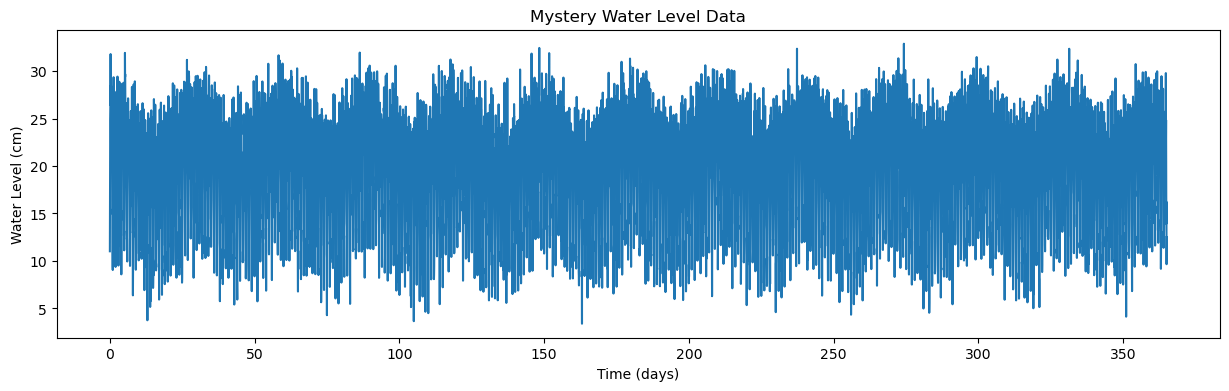

In [26]:
plt.figure(figsize=(15,4))
plt.plot(time,level)
plt.xlabel('Time (days)')
plt.ylabel('Water Level (cm)')
plt.title('Mystery Water Level Data');

**For your homework**

Use Fourier analysis, as we did on our fake data above, to determine what are the dominant frequencies (and periods) of this timeseries.  Based on this analysis, where do you think this water level was measured?